## Parameter estimation: Normal

Parameter estimation is the strongest method of VaR estimation because it assumes that the loss distribution class is known. Parameters are estimated to fit data to this distribution, and statistical inference is then made.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pandas_datareader import DataReader
from datetime import datetime

stocklist = ['C', 'MS', 'GS', 'JPM']

start = datetime(2004,12,31)
end = datetime(2010,12,31)

portfolio = DataReader(stocklist, 'yahoo',start, end)['Close']
portfolio.rename(columns={'C':'Citibank', 'MS':'Morgan Stanley','GS':'Goldman Sachs','JPM':'J.P. Morgan'}, inplace=True)
print(portfolio.head())

weights = [0.25, 0.25, 0.25, 0.25]

Symbols       Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Date                                                              
2004-12-31  481.799988       55.520000     104.040001    39.009998
2005-01-03  482.700012       55.900002     104.949997    39.150002
2005-01-04  478.600006       55.299999     104.269997    38.410000
2005-01-05  484.600006       54.980000     103.800003    38.490002
2005-01-06  489.299988       56.279999     105.230003    38.709999


In [2]:
# Compute the portfolio's daily returns
portfolio_returns = portfolio.pct_change().dot(weights).dropna()

# Compute the portfolio's daily losses
portfolio_losses = -portfolio_returns.dropna()

In [3]:
# Import the Normal distribution and skewness test from scipy.stats
from scipy.stats import norm, anderson

# Fit portfolio losses to the Normal distribution
params = norm.fit(portfolio_losses)

# Compute the 95% VaR from the fitted distribution, using parameter estimates
VaR_95 = norm.ppf(0.95, *params)
print("VaR_95, Normal distribution: ", VaR_95)

# Test the data for Normality
print("Anderson-Darling test result: ", anderson(portfolio_losses))

VaR_95, Normal distribution:  0.053938106880521725
Anderson-Darling test result:  AndersonResult(statistic=86.57275579677253, critical_values=array([0.574, 0.654, 0.785, 0.916, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


## Parameter estimation: Skewed Normal

We'll parametrically estimate the 95% VaR of a loss distribution fit. This is a more general distribution than the Normal and allows losses to be non-symmetrically distributed. We might expect losses to be skewed during the crisis, when portfolio losses were more likely than gains.

In [4]:
# Import the skew-normal distribution and skewness test from scipy.stats
from scipy.stats import skewnorm, skewtest

# Fit the Student's t distribution to crisis losses
crisis_losses = portfolio_losses.loc['2008-01-01':'2009-12-31']

# Test the data for skewness
print("Skewtest result: ", skewtest(crisis_losses))

# Fit the portfolio loss data to the skew-normal distribution
params = skewnorm.fit(crisis_losses)

# Compute the 95% VaR from the fitted distribution, using parameter estimates
VaR_95 = skewnorm.ppf(0.95, *params)
print("VaR_95 from skew-normal: ", VaR_95)

Skewtest result:  SkewtestResult(statistic=-9.46377341649772, pvalue=2.9702650510105885e-21)
VaR_95 from skew-normal:  0.07953135436049741


The Anderson-Darling and skewtest results show the Normal distribution estimates cannot be relied upon. Skewness matters for loss distributions, and parameter estimation is one way to quantify this important feature of the financial crisis.

## Historical Simulation


Historical simulation of VaR assumes that the distribution of historical losses is the same as the distribution of future losses. We'll test if this is true for our investment bank portfolio by comparing the 95% VaR from 2005 - 2006 to the 95% VaR from 2007 - 2009.

In [5]:
import numpy as np

asset_returns_list = [portfolio['2005-01-01':'2006-12-31'].pct_change().dropna(), portfolio['2007-01-01':'2008-12-31'].pct_change().dropna()]

# Create portfolio returns for the two sub-periods using the list of asset returns
portfolio_returns_list = np.array([ x.dot(weights) for x in asset_returns_list])

# Derive portfolio losses from portfolio returns
losses = - portfolio_returns_list

# Find the historical simulated VaR estimates
VaR_95 = [np.quantile(x, 0.95) for x in losses]

# Display the VaR estimates
print("VaR_95, 2005-2006: ", VaR_95[0], '; VaR_95, 2007-2009: ', VaR_95[1])

VaR_95, 2005-2006:  0.01470023008198797 ; VaR_95, 2007-2009:  0.05492612537506693


The VaR estimates are very different for the two time periods. This indicates that over the entire 2005 - 2009 period the loss distribution was likely not stationary. Historical simulation, while very general, should be used with caution when the data is not from a stationary distribution.

## Monte Carlo Simulation

We can use Monte Carlo simulation of the 2005-2010 investment bank portfolio assets to find the 95% VaR.

In [6]:
from pypfopt.risk_models import CovarianceShrinkage

# Create the CovarianceShrinkage instance variable
cs = CovarianceShrinkage(portfolio)

# Compute the efficient covariance matrix of returns
e_cov = cs.ledoit_wolf()/252
e_cov = e_cov.to_numpy()

# Compute the mean and volatility
mu = np.array(-portfolio.pct_change().dropna().mean()).reshape((4,1))
sigma = np.array(-portfolio.pct_change().dropna().std()).reshape((4,1))

total_steps = 1440
N = 10000

In [7]:
# Initialize daily cumulative loss for the assets, across N runs
daily_loss = np.zeros((4,N))

# Create the Monte Carlo simulations for N runs
for n in range(N):
    # Compute simulated path of length total_steps for correlated returns
    correlated_randomness = e_cov @ norm.rvs(size = (4,total_steps))
    # Adjust simulated path by total_steps and mean of portfolio losses
    steps = 1/total_steps
    minute_losses = mu * steps + correlated_randomness * np.sqrt(steps)
    daily_loss[:, n] = minute_losses.sum(axis=1)
    
# Generate the 95% VaR estimate
losses = weights @ daily_loss
print("Monte Carlo VaR_95 estimate: ", np.quantile(losses, 0.95))

Monte Carlo VaR_95 estimate:  0.0032139721831846947


We've shown how Monte Carlo simulation can be used to create an entire range of possible outcomes when the underlying risk factor distributions are known. The resulting riskiness of the loss distribution can then be assessed using the VaR estimate, or a more complicated estimate such as CVaR.

## Crisis structural break: I

We have already seen in Chapters 1 and 2 that the global financial crisis changed investor perception regarding market risk, and influenced investor decisions on portfolio allocations to manage risk.

Now we'll have a chance to investigate whether something "structural" changed between 2005 and 2010. In this exercise you can see if quarterly minimum portfolio values and mean return volatility time series together identify a structural break.

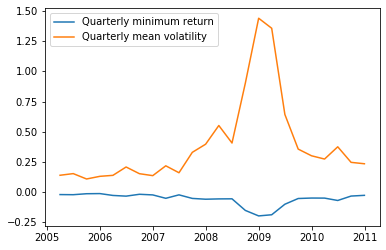

In [8]:
import matplotlib.pyplot as plt

port_q_min = portfolio_returns.resample('Q').min()
vol_q_mean = portfolio_returns.resample('Q').std()*np.sqrt(252)

# Create a plot of quarterly minimum portfolio returns
plt.plot(port_q_min, label="Quarterly minimum return")

# Create a plot of quarterly mean volatility
plt.plot(vol_q_mean, label="Quarterly mean volatility")

# Create legend and plot
plt.legend()
plt.show()

As we can see from the visualization, there appears to be a discrete change somewhere in the first half of 2008, but it's unclear if this is just a temporary 'blip' or something more structural. We'll now proceed to test this by building the Chow test statistic.

In [9]:
import pandas as pd

# Read mortgage delinquency rate historical data from FRED https://fred.stlouisfed.org/series/DRSFRMACBS
mort_del = pd.read_csv('C:/Users/Renan/Desktop/Python/Portfolio/Quantitative Risk Management/datasets/DRSFRMACBS.csv'\
                       , index_col=0)

mort_del.rename(columns={'DRSFRMACBS':'Mortgage Delinquency Rate'}, inplace=True)

mort_del = mort_del.loc['2005-04-01':'2011-01-01']/100

print(mort_del.shape)
print(type(mort_del))

(24, 1)
<class 'pandas.core.frame.DataFrame'>


In [10]:
# Align indexes
mort_del = mort_del.set_index(port_q_min.index)

In [11]:
# Import the statsmodels API to be able to run regressions
import statsmodels.api as sm

# Add a constant to the regression
mort_del_with_intercept = sm.add_constant(mort_del)

# Regress quarterly minimum portfolio returns against mortgage delinquencies
result = sm.OLS(port_q_min, mort_del_with_intercept).fit()

# Retrieve the sum-of-squared residuals
ssr_total = result.ssr
print("Sum-of-squared residuals, 2005-2010: ", ssr_total)

Sum-of-squared residuals, 2005-2010:  0.05038727148429893


The sum-of-squared residual total we found here will be used to build the Chow test for the crisis period!

In [12]:
before = pd.concat([mort_del.loc['2005-03-31':'2008-06-30'], port_q_min.loc['2005-03-31':'2008-06-30']], axis=1)
before = before.rename(columns={0:'Returns'})

after = pd.concat([mort_del.loc['2008-09-30':'2010-12-31'], port_q_min.loc['2008-09-30':'2010-12-31']], axis=1)
after = after.rename(columns={0:'Returns'})

# Add intercept constants to each sub-period 'before' and 'after'
before_with_intercept = sm.add_constant(before['Mortgage Delinquency Rate'])
after_with_intercept  = sm.add_constant(after['Mortgage Delinquency Rate'])

# Fit OLS regressions to each sub-period
r_b = sm.OLS(before['Returns'], before_with_intercept).fit()
r_a = sm.OLS(after['Returns'],  after_with_intercept).fit()

# Get sum-of-squared residuals for both regressions
ssr_before = r_b.ssr
ssr_after = r_a.ssr
# Compute and display the Chow test statistic
numerator = ((ssr_total - (ssr_before + ssr_after)) / 2)
denominator = ((ssr_before + ssr_after) / (24 - 4))
print("Chow test statistic: ", numerator / denominator)

Chow test statistic:  29.1140825843009


Our test statistic was well above the critical F-value, indicating that a structural break in the data occurred in the summer of 2008. 